## usage
```first run pip install -e . ```
from cocite/mlpipeline/

which command creates an editable install

In [225]:
# import package from mlpipeline
from config import cmd_arguments
import cocitedata as cocitedata
import citation_normalization as cn
import matplotlib.pyplot as plt
import os
import pandas as pd
import tqdm

num_documents = 10000

def load_data():
    testargs = ["--data_dir", "../../external_projects/bva-citation-prediction/data/preprocessed-cached/preprocessed-cached-v4/", 
    # "--samples", str(num_documents),
    "--rebuild_dataset",
    "--dont_normalize_citations"
    ]

    args = cmd_arguments(testargs=testargs)
    data_dir_name = cocitedata.dataset_filepath(args)
    cocitedata.generate_ds_if_not_cached(data_dir_name, args)
    parquet_files = [os.path.join(data_dir_name, f) for f in os.listdir(data_dir_name) if f.endswith('.parquet')]
    return parquet_files

files = load_data()

reading json files into df


  1%|          | 1/100 [00:01<02:04,  1.25s/it]

finished converting batch nr.  0 to df


  2%|▏         | 2/100 [00:02<02:01,  1.24s/it]

skip citation 30 [1488, 1508, 1778, 1964, 2317, 2604, 2801, 2937, 3019, 5437, 5460, 5584, 5600, 5647, 5912, 5932, 6010, 6285, 6393, 6599, 6766, 6783, 7590, 7600, 7693, 11111, 11133, 11993, 12601, 12616]
finished converting batch nr.  1 to df


  3%|▎         | 3/100 [00:03<02:01,  1.25s/it]

finished converting batch nr.  2 to df
skip citation 41 [1128, 1148, 1418, 1604, 1957, 2244, 2650, 2852, 2988, 3070, 4747, 6101, 6124, 6248, 6264, 6311, 6576, 6596, 6674, 6949, 7057, 7263, 7430, 7447, 7624, 7778, 8033, 9076, 9086, 9105, 10291, 12771, 13153, 13759, 14118, 14133, 14380, 14851, 15197, 15217, 15223]


  4%|▍         | 4/100 [00:04<01:54,  1.20s/it]

finished converting batch nr.  3 to df


  5%|▌         | 5/100 [00:05<01:49,  1.15s/it]

finished converting batch nr.  4 to df
skip citation 52 [1856, 1876, 1927, 1963, 2248, 2434, 2787, 3074, 3480, 3886, 4088, 4224, 4306, 7168, 7191, 7315, 7331, 7378, 7643, 7663, 7741, 8016, 8124, 8330, 8497, 8514, 8725, 8731, 8986, 9673, 9683, 10399, 10405, 10429, 10898, 12877, 13725, 13898, 15197, 15395, 16086, 16445, 17087, 17505, 28433, 28955, 28970, 29327, 29799, 30145, 30165, 30171]


  6%|▌         | 6/100 [00:06<01:39,  1.06s/it]

finished converting batch nr.  5 to df


  7%|▋         | 7/100 [00:07<01:28,  1.05it/s]

finished converting batch nr.  6 to df


  8%|▊         | 8/100 [00:08<01:20,  1.14it/s]

finished converting batch nr.  7 to df


  9%|▉         | 9/100 [00:08<01:14,  1.22it/s]

finished converting batch nr.  8 to df


 10%|█         | 10/100 [00:09<01:10,  1.27it/s]

finished converting batch nr.  9 to df


 11%|█         | 11/100 [00:10<01:07,  1.31it/s]

finished converting batch nr.  10 to df


 12%|█▏        | 12/100 [00:11<01:07,  1.29it/s]

finished converting batch nr.  11 to df


 13%|█▎        | 13/100 [00:11<01:06,  1.32it/s]

finished converting batch nr.  12 to df


 14%|█▍        | 14/100 [00:12<01:04,  1.34it/s]

finished converting batch nr.  13 to df


 15%|█▌        | 15/100 [00:13<01:02,  1.36it/s]

finished converting batch nr.  14 to df


 16%|█▌        | 16/100 [00:14<01:01,  1.37it/s]

finished converting batch nr.  15 to df


 17%|█▋        | 17/100 [00:14<01:00,  1.37it/s]

finished converting batch nr.  16 to df


 18%|█▊        | 18/100 [00:15<00:59,  1.38it/s]

finished converting batch nr.  17 to df


 19%|█▉        | 19/100 [00:16<00:58,  1.38it/s]

finished converting batch nr.  18 to df


 20%|██        | 20/100 [00:16<00:57,  1.39it/s]

finished converting batch nr.  19 to df


 21%|██        | 21/100 [00:17<00:56,  1.40it/s]

finished converting batch nr.  20 to df


 22%|██▏       | 22/100 [00:18<00:56,  1.39it/s]

finished converting batch nr.  21 to df


 23%|██▎       | 23/100 [00:19<00:57,  1.34it/s]

finished converting batch nr.  22 to df


 24%|██▍       | 24/100 [00:19<00:58,  1.30it/s]

finished converting batch nr.  23 to df


 25%|██▌       | 25/100 [00:20<00:56,  1.33it/s]

finished converting batch nr.  24 to df


 26%|██▌       | 26/100 [00:21<00:55,  1.33it/s]

finished converting batch nr.  25 to df


 27%|██▋       | 27/100 [00:22<00:58,  1.26it/s]

finished converting batch nr.  26 to df


 28%|██▊       | 28/100 [00:23<00:55,  1.29it/s]

finished converting batch nr.  27 to df


 29%|██▉       | 29/100 [00:23<00:53,  1.33it/s]

finished converting batch nr.  28 to df


 30%|███       | 30/100 [00:24<00:52,  1.32it/s]

finished converting batch nr.  29 to df


 31%|███       | 31/100 [00:25<00:52,  1.30it/s]

finished converting batch nr.  30 to df


 32%|███▏      | 32/100 [00:26<00:51,  1.32it/s]

finished converting batch nr.  31 to df


 33%|███▎      | 33/100 [00:26<00:52,  1.29it/s]

finished converting batch nr.  32 to df


 34%|███▍      | 34/100 [00:27<00:50,  1.30it/s]

finished converting batch nr.  33 to df


 35%|███▌      | 35/100 [00:28<00:52,  1.24it/s]

finished converting batch nr.  34 to df


 36%|███▌      | 36/100 [00:29<00:50,  1.26it/s]

finished converting batch nr.  35 to df


 37%|███▋      | 37/100 [00:30<00:48,  1.29it/s]

finished converting batch nr.  36 to df


 38%|███▊      | 38/100 [00:30<00:47,  1.30it/s]

finished converting batch nr.  37 to df


 39%|███▉      | 39/100 [00:31<00:46,  1.31it/s]

finished converting batch nr.  38 to df


 40%|████      | 40/100 [00:32<00:48,  1.25it/s]

finished converting batch nr.  39 to df


 41%|████      | 41/100 [00:33<00:45,  1.30it/s]

finished converting batch nr.  40 to df


 42%|████▏     | 42/100 [00:33<00:43,  1.34it/s]

finished converting batch nr.  41 to df


 43%|████▎     | 43/100 [00:34<00:41,  1.38it/s]

finished converting batch nr.  42 to df


 44%|████▍     | 44/100 [00:35<00:40,  1.40it/s]

finished converting batch nr.  43 to df


 45%|████▌     | 45/100 [00:35<00:39,  1.39it/s]

finished converting batch nr.  44 to df


 46%|████▌     | 46/100 [00:36<00:38,  1.39it/s]

finished converting batch nr.  45 to df


 47%|████▋     | 47/100 [00:37<00:38,  1.37it/s]

finished converting batch nr.  46 to df


 48%|████▊     | 48/100 [00:38<00:42,  1.22it/s]

finished converting batch nr.  47 to df


 49%|████▉     | 49/100 [00:39<00:46,  1.10it/s]

finished converting batch nr.  48 to df
skip citation 40 [2448, 2465, 2985, 3604, 3812, 4161, 4486, 4512, 4725, 5259, 5489, 6048, 6054, 6484, 6688, 8477, 8872, 8878, 9144, 9268, 9679, 9685, 10167, 10762, 11316, 11463, 11473, 12347, 13282, 13400, 13408, 13504, 13512, 14213, 14219, 14225, 14588, 14861, 14867, 15499]


 50%|█████     | 50/100 [00:40<00:42,  1.16it/s]

finished converting batch nr.  49 to df


 51%|█████     | 51/100 [00:40<00:40,  1.22it/s]

finished converting batch nr.  50 to df


 52%|█████▏    | 52/100 [00:41<00:38,  1.26it/s]

finished converting batch nr.  51 to df


 53%|█████▎    | 53/100 [00:42<00:36,  1.29it/s]

finished converting batch nr.  52 to df


 54%|█████▍    | 54/100 [00:43<00:34,  1.32it/s]

finished converting batch nr.  53 to df


 55%|█████▌    | 55/100 [00:43<00:34,  1.31it/s]

finished converting batch nr.  54 to df


 56%|█████▌    | 56/100 [00:44<00:35,  1.26it/s]

finished converting batch nr.  55 to df


 57%|█████▋    | 57/100 [00:45<00:36,  1.17it/s]

finished converting batch nr.  56 to df


 58%|█████▊    | 58/100 [00:46<00:35,  1.19it/s]

finished converting batch nr.  57 to df


 59%|█████▉    | 59/100 [00:47<00:33,  1.24it/s]

finished converting batch nr.  58 to df


 60%|██████    | 60/100 [00:48<00:32,  1.25it/s]

finished converting batch nr.  59 to df


 61%|██████    | 61/100 [00:48<00:31,  1.24it/s]

finished converting batch nr.  60 to df


 62%|██████▏   | 62/100 [00:49<00:29,  1.30it/s]

finished converting batch nr.  61 to df


 63%|██████▎   | 63/100 [00:50<00:27,  1.32it/s]

finished converting batch nr.  62 to df


 64%|██████▍   | 64/100 [00:51<00:26,  1.34it/s]

finished converting batch nr.  63 to df


 65%|██████▌   | 65/100 [00:51<00:26,  1.31it/s]

finished converting batch nr.  64 to df


 66%|██████▌   | 66/100 [00:52<00:26,  1.30it/s]

finished converting batch nr.  65 to df
skip citation 33 [1839, 2862, 3754, 5024, 5873, 6682, 7822, 9527, 9723, 9786, 9893, 9931, 10573, 10635, 12745, 18281, 18321, 18344, 18618, 19083, 19091, 19955, 20573, 21127, 21491, 21814, 23224, 23976, 23984, 24916, 25356, 25761, 26051]


 67%|██████▋   | 67/100 [00:53<00:25,  1.32it/s]

finished converting batch nr.  66 to df


 68%|██████▊   | 68/100 [00:54<00:24,  1.31it/s]

finished converting batch nr.  67 to df


 69%|██████▉   | 69/100 [00:54<00:23,  1.30it/s]

finished converting batch nr.  68 to df


 70%|███████   | 70/100 [00:55<00:22,  1.33it/s]

finished converting batch nr.  69 to df


 71%|███████   | 71/100 [00:56<00:21,  1.36it/s]

finished converting batch nr.  70 to df


 72%|███████▏  | 72/100 [00:57<00:21,  1.28it/s]

finished converting batch nr.  71 to df


 73%|███████▎  | 73/100 [00:58<00:21,  1.26it/s]

finished converting batch nr.  72 to df


 74%|███████▍  | 74/100 [00:58<00:20,  1.24it/s]

finished converting batch nr.  73 to df


 75%|███████▌  | 75/100 [00:59<00:20,  1.20it/s]

finished converting batch nr.  74 to df


 76%|███████▌  | 76/100 [01:00<00:19,  1.22it/s]

finished converting batch nr.  75 to df


 77%|███████▋  | 77/100 [01:01<00:18,  1.23it/s]

finished converting batch nr.  76 to df


 78%|███████▊  | 78/100 [01:02<00:17,  1.28it/s]

finished converting batch nr.  77 to df


 79%|███████▉  | 79/100 [01:02<00:16,  1.26it/s]

finished converting batch nr.  78 to df


 80%|████████  | 80/100 [01:03<00:15,  1.30it/s]

finished converting batch nr.  79 to df


 81%|████████  | 81/100 [01:04<00:14,  1.30it/s]

finished converting batch nr.  80 to df


 82%|████████▏ | 82/100 [01:05<00:13,  1.31it/s]

finished converting batch nr.  81 to df


 83%|████████▎ | 83/100 [01:05<00:13,  1.30it/s]

finished converting batch nr.  82 to df


 84%|████████▍ | 84/100 [01:06<00:12,  1.31it/s]

finished converting batch nr.  83 to df


 85%|████████▌ | 85/100 [01:07<00:11,  1.31it/s]

finished converting batch nr.  84 to df


 86%|████████▌ | 86/100 [01:08<00:10,  1.32it/s]

finished converting batch nr.  85 to df


 87%|████████▋ | 87/100 [01:08<00:09,  1.34it/s]

finished converting batch nr.  86 to df


 88%|████████▊ | 88/100 [01:09<00:08,  1.36it/s]

finished converting batch nr.  87 to df


 89%|████████▉ | 89/100 [01:10<00:08,  1.36it/s]

finished converting batch nr.  88 to df


 90%|█████████ | 90/100 [01:11<00:07,  1.36it/s]

finished converting batch nr.  89 to df


 91%|█████████ | 91/100 [01:11<00:06,  1.37it/s]

finished converting batch nr.  90 to df


 92%|█████████▏| 92/100 [01:12<00:05,  1.36it/s]

finished converting batch nr.  91 to df


 93%|█████████▎| 93/100 [01:13<00:05,  1.38it/s]

finished converting batch nr.  92 to df


 94%|█████████▍| 94/100 [01:14<00:04,  1.37it/s]

finished converting batch nr.  93 to df


 95%|█████████▌| 95/100 [01:14<00:03,  1.29it/s]

finished converting batch nr.  94 to df


 96%|█████████▌| 96/100 [01:15<00:03,  1.22it/s]

finished converting batch nr.  95 to df


 97%|█████████▋| 97/100 [01:16<00:02,  1.17it/s]

finished converting batch nr.  96 to df


 98%|█████████▊| 98/100 [01:17<00:01,  1.20it/s]

finished converting batch nr.  97 to df


 99%|█████████▉| 99/100 [01:18<00:00,  1.22it/s]

finished converting batch nr.  98 to df


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


finished converting batch nr.  99 to df
dropped 0 elements for not finding their source docs
total samples 0
adding occurance counts to data
reading parquet files into df


100%|██████████| 100/100 [00:02<00:00, 48.57it/s]


finished saving occurance counts to  ../data/generated_bva_variants/model__unfinished/occurrences.csv


100%|██████████| 100/100 [00:01<00:00, 55.03it/s]


finished adding occurance counts to parquet files
saved df to parquet ../data/generated_bva_variants/model_/


In [221]:
normalization_types = ["no normalization", "normalized", "no sub subsections", "no subsections"]
counts = {}
segmented_counts = {}
for ntype in normalization_types:
    counts[ntype] = pd.Series(dtype=int)
    segmented_counts[ntype] = pd.Series(dtype=int)

examples = []
for path in tqdm.tqdm(files):
    df = pd.read_parquet(path)
    df["no normalization"] = df["label"].copy()
    df["normalized"] = df.apply(lambda row: cn.normalize_citation(row["label"], remove_subsections=False, remove_subsubsections=False), axis=1)
    df["no sub subsections"] = df.apply(lambda row: cn.normalize_citation(row["label"], remove_subsections=False, remove_subsubsections=True), axis=1)
    df["no subsections"] = df.apply(lambda row: cn.normalize_citation(row["label"], remove_subsections=True, remove_subsubsections=True), axis=1)
 
    for ntype in normalization_types:        
        counts[ntype] = counts[ntype].add(df[ntype].value_counts(), fill_value=0)

        segmented = df.apply(lambda row: cn.segmentize_citation(row[ntype]), axis=1)
        segmented = segmented.apply(pd.Series).stack().reset_index(drop = True)
        segmented_counts[ntype] = segmented_counts[ntype].add(segmented.value_counts(), fill_value=0)        
        
        examples.append(df.loc[1][ntype])


100%|██████████| 100/100 [02:23<00:00,  1.44s/it]


In [248]:


# number of unique values in each normalization type
bars = []
segmented_bars = []
for ntype in normalization_types:
    bars.append(len(counts[ntype]))
    segmented_bars.append(len(segmented_counts[ntype]))

titles = [ntype + ": \n" + example for (ntype, example) in zip(normalization_types, examples)]

total_count = counts["no normalization"].sum()


In [252]:
# plot bars with plotly
import plotly.graph_objects as go
# horizontal bar chart
fig = go.Figure()

fig.add_bar(x=bars, y=titles, orientation="h", name="not segmented")
fig.add_bar(x=segmented_bars, y=titles, orientation="h", name="segmented")
# stacked bars
# fig.update_layout(barmode="stack")

fig.update_layout(title_text="Citation normalization")
fig.update_yaxes(title_text="normalization types")
fig.update_xaxes(title_text=f"number of unique citations (from total of {int(total_count)} citation pairs)")
# make xaxes labels vertical
fig.update_layout(xaxis_tickangle=-90)

fig.update_layout(width=900, height=500)
fig.show()


TypeError: unhashable type: 'slice'

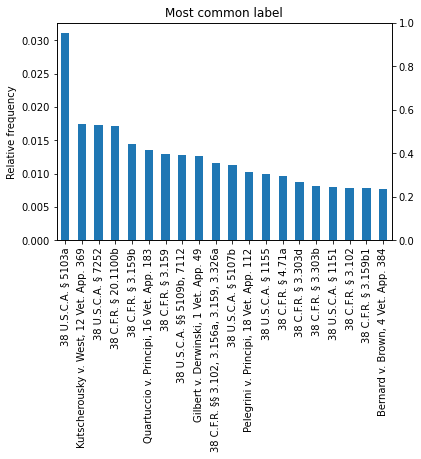

In [201]:
plt.title("Most common label")
relative_counts[:20].plot(kind="bar")
# ylabel
plt.ylabel("Relative frequency")
# second ylabel absolute frequency
plt.twinx()
counts[:20].plot(kind="bar")
plt.ylabel("Absolute frequency")
plt.show()

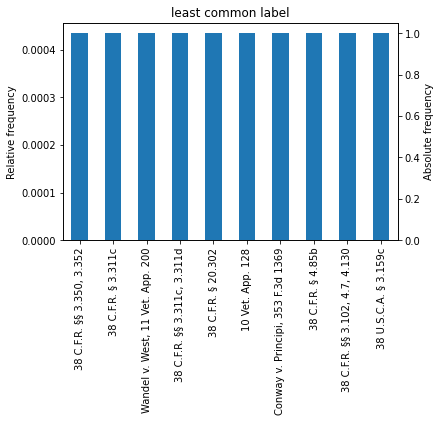

In [8]:
plt.title("least common label")
relative_counts[-10:].plot(kind="bar")
# ylabel
plt.ylabel("Relative frequency")
# second ylabel absolute frequency
plt.twinx()
counts[-10:].plot(kind="bar")
plt.ylabel("Absolute frequency")
plt.show()

In [9]:
import plotly.express as px

def plot_percentiles(percentiles, counts):
    citations_per_percentile = counts.quantile(percentiles)
    # create the same scatter plot in plotly

    fig = px.scatter(x=percentiles, y=citations_per_percentile, labels={"x": "percentile", "y": "avg Number of citations"}, log_y=True)
    title = "percentiles of citations per document"
    fig.update_layout(title_text=title)
    fig.update_xaxes(title_text="percentile")
    fig.update_yaxes(title_text="avg Number of citations")
    fig.show()



In [10]:
percentiles = [(i/100) for i in range(0, 100)]
plot_percentiles(percentiles, counts)
percentiles = [(i/10000 + 0.99) for i in range(0, 100)]
plot_percentiles(percentiles, counts)


In [11]:
# loop through csv files and add the counts to the csv data

